In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
from matplotlib import rcParams
from pandas_datareader.data import DataReader

C:\Users\jasonyip184\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
mdf = pd.read_csv('data_m_original - Copy.csv').set_index('Indicator').T
mdf.index = [str(pd.Timestamp(x))[:7] for x in list(mdf.index)]
qdf = pd.read_csv('data_q_original - Copy.csv').set_index('Indicator').T

for col in mdf.columns:
    if col[-2:] == '_1':
        mdf[col] = mdf[col].diff()
    elif col[-2:] == 'n1':
        mdf[col] = np.log(mdf[col]).diff()
    elif col[-2:] == 'n2':
        mdf[col] = np.log(mdf[col]).diff().diff()

for col in qdf.columns[1:]:
    if col[-2:] == '_1':
        qdf[col] = qdf[col].diff()
    elif col[-2:] == 'n1':
        qdf[col] = np.log(qdf[col]).diff()
    elif col[-2:] == 'n2':
        qdf[col] = np.log(qdf[col]).diff().diff()
        
def f(date):
    end = None
    if date[-2] == '1':
        end = '-03'
    if date[-2] == '2':
        end = '-06'
    if date[-2] == '3':
        end = '-09'
    if date[-2] == '4':
        end = '-12'
    return date[:4]+end
qdf.index = [f(x) for x in list(qdf.index)]

start = qdf.index[2]
df = pd.concat([qdf,mdf],axis=1,join='outer')
df.index = pd.DatetimeIndex(df.index).to_period('M')
df.sort_index(inplace=True)
df = df.loc[start:]
for col in df.columns[1:]:
    df[col] = (df[col]-df[col].mean())/df[col].std()
df

Indicator,Real GDP Growth Rate,Domestic Wholesale Trade Index_ln1,Foreign Wholesale Trade Index_ln1,Unit Labour Cost Of Overall Economy_ln1,Real Value Added Per Worker,Total Unemployment Rate_1,Real Gross Fixed Capital Formation_ln2,Total Government Debt_ln2,Business Expectations Of Manufacturing Sector (Next 6 Months)_1,Business Expectations Of Services Sector (Next 6 Months)_1,...,Govt 1-year Treasury Bills Yield_1,Govt 5-year Bond Yield_1,M3_ln2,M2_ln2,M1_ln2,Loans & Advances Of Banks Including Bills Financing_ln2,Total Official Foreign Reserves_ln2,"Building, Real Estate, Construction and Housing Contracts Awarded_ln1",Electricity Generation_ln1,Cessation Of Business Entities_ln1
1995-09,0.294544,1.001712,1.933425,-0.157973,0.282142,-1.506592,0.266892,-0.476540,-0.076332,0.848618,...,-0.146742,-0.487283,-0.490275,-0.305282,-0.143197,-0.535973,-0.216490,-0.206744,0.015587,3.243134
1995-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.576117,-0.439950,-0.335442,-0.329656,-0.461575,-0.314717,0.376119,0.083828,0.006107,-2.973032
1995-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.204565,-0.108624,1.465294,1.044778,0.186186,0.643759,-0.152949,1.089610,-0.589172,-0.466868
1995-12,0.040952,1.012751,1.676915,1.777748,-0.080550,0.698777,0.736335,-0.012540,0.048575,-1.346501,...,-0.732254,-0.345286,-0.001283,-0.115832,1.252406,-0.418847,-0.164477,-0.355863,-0.119867,3.855168
1996-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.477804,-0.013959,-1.971780,-1.030119,-0.019212,0.566557,0.506619,-0.869993,0.389387,-2.472286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.107708,-0.061291,0.626896,0.390298,0.578777,-0.188896,0.074665,-0.102871,-0.604177,-0.048778
2019-12,0.030943,-0.071691,1.182544,0.964404,-0.528581,0.002345,0.285235,-1.309271,1.110290,-0.149163,...,0.321668,-0.250621,-0.844891,-0.541638,-1.322031,-0.423244,-0.359556,0.089687,-0.028506,-0.053702
2020-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.888391,-0.534615,1.353350,0.872952,1.133359,-0.102350,0.937415,-0.547527,NaN,0.024218
2020-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.165531,-0.723944,-0.677846,-0.435237,-0.172965,0.349686,1.481957,-0.453524,NaN,-0.165882


 In general, first differences of logarithms (growth rates) are used for real
quantity variables, first differences are used for nominal interest rates, and second
differences of logarithms (changes in growth rates) for price series.
https://www.princeton.edu/~mwatson/papers/favar.pdf

In [713]:
# # Create the model
mod = sm.tsa.DynamicFactor(df, k_factors=1, factor_order=2, error_order=2)
res = mod.fit(disp=False)

C:\Users\jasonyip184\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [4]:
resultdf = pd.DataFrame({'Nowcasted Real GDP Growth':res.predict()['Real GDP Growth Rate'],'Actual Real GDP Growth':df['Real GDP Growth Rate']})
resultdf

,Nowcasted Real GDP Growth,Actual Real GDP Growth
1995-09,0.000000,0.294544
1995-10,0.113933,NaN
1995-11,0.234494,NaN
1995-12,0.139252,0.040952
1996-01,0.131825,NaN
...,...,...
2019-11,0.055819,NaN
2019-12,0.001669,0.030943
2020-01,0.020510,NaN
2020-02,0.017820,NaN


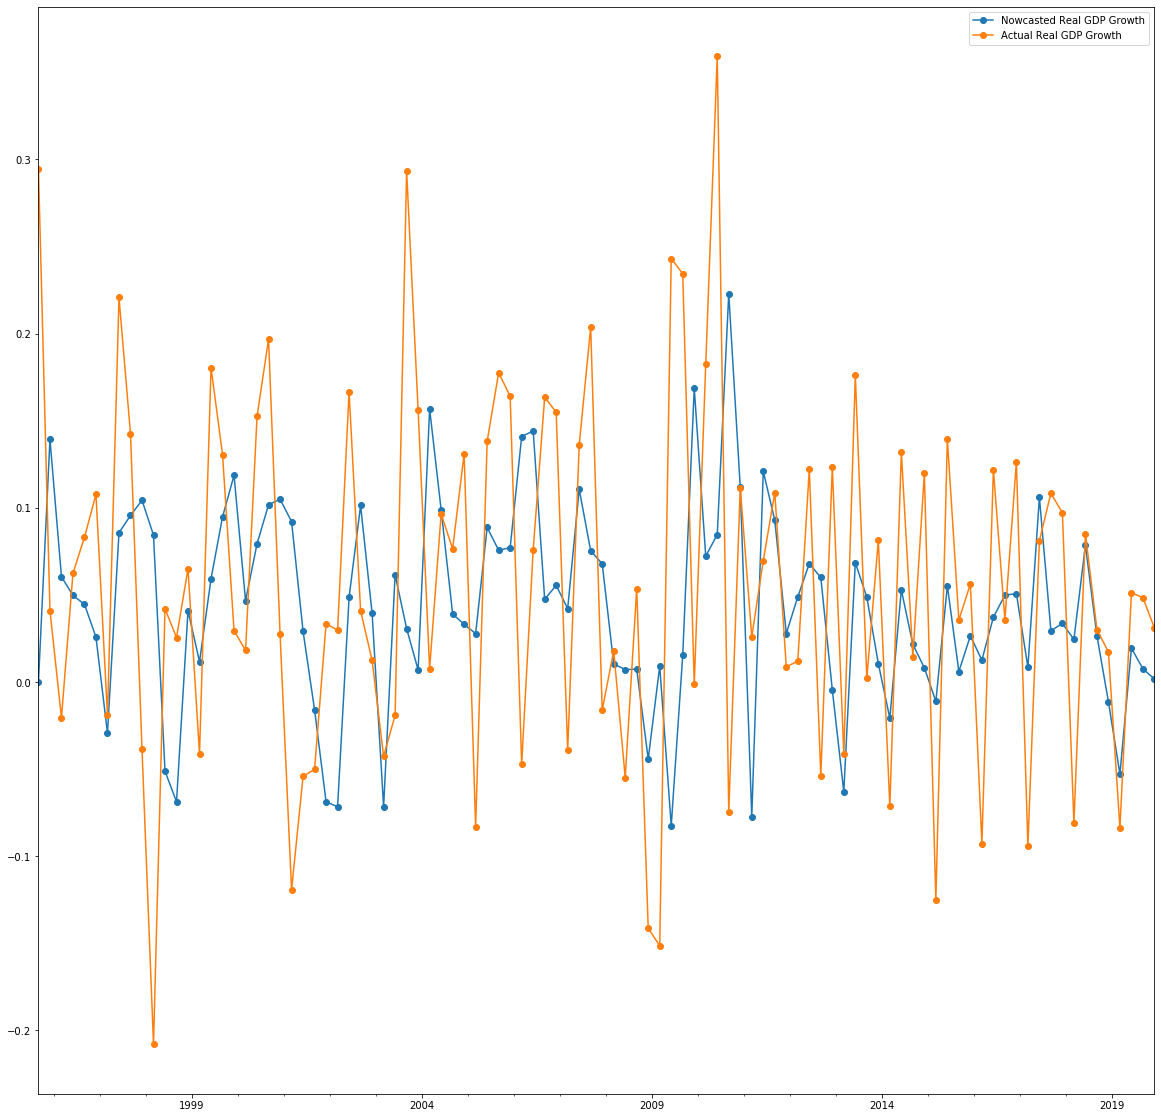

In [5]:
resultdf.dropna().plot(marker='o',linestyle='-',figsize=(20,20))

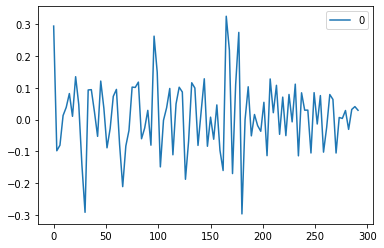

In [6]:
pd.DataFrame(res.filter_results.forecasts_error[0]).dropna().plot()

In [7]:
resultdf = pd.DataFrame({'Nowcasted Real GDP Growth':res.filter_results.smoothed_forecasts[0],'Actual Real GDP Growth':df['Real GDP Growth Rate']})*100
resultdf

,Nowcasted Real GDP Growth,Actual Real GDP Growth
1995-09,29.454377,29.454377
1995-10,0.883589,NaN
1995-11,19.675317,NaN
1995-12,4.095188,4.095188
1996-01,12.577819,NaN
...,...,...
2019-11,5.855734,NaN
2019-12,3.094270,3.094270
2020-01,-1.108426,NaN
2020-02,5.761391,NaN


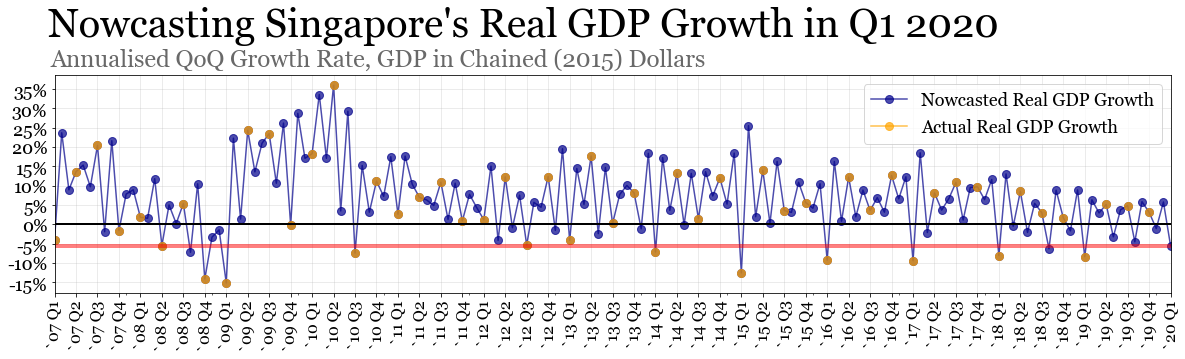

In [73]:
plotdf = resultdf.iloc[-157:]
def f(date):
    end = ''
    if date[-1] == '3':
        end = ' Q1'
    if date[-1] == '6':
        end = ' Q2'
    if date[-1] == '9':
        end = ' Q3'
    if date[-2:] == '12':
        end = ' Q4'
    return "`"+date[2:4]+end
plotdf_labels = [f(str(x)) for x in list(plotdf.index)]
rcParams['font.family'] = 'Georgia'
ax = plotdf.plot(marker='o',linestyle='-',figsize=(20,4),alpha=0.7,color=['darkblue','orange'],markersize=8)
ax.set_yticks(np.arange(-15, 40, 5))
ax.set_yticklabels([str(x)+'%' for x in np.arange(-15, 40, 5)],fontsize=18)
ax.set_xticks(plotdf.index[::3])
ax.set_xticklabels(plotdf_labels[::3], rotation=90,fontsize=16)
ax.grid('on', alpha=0.3)
ax.axhline(y=plotdf['Nowcasted Real GDP Growth'][-1],alpha=0.5,linewidth=4,color='red');
ax.axhline(y=0,alpha=1,linewidth=2,color='black');
ax.legend(prop={'size':18});
ax.set_title('Nowcasting Singapore\'s Real GDP Growth in Q1 2020',fontsize=40,y=1.15,x=0.42);
plt.suptitle("Annualised QoQ Growth Rate, GDP in Chained (2015) Dollars",fontsize=24,y=0.975,x=0.35,color='dimgrey');
# plt.savefig('myimage.png', format='png', dpi=1200)

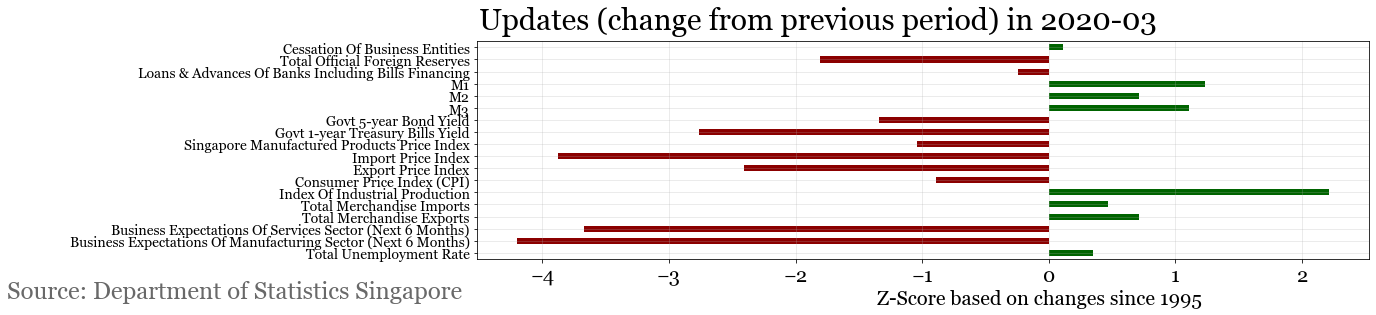

In [68]:
news = list(df.iloc[-1][df.iloc[-1].notnull()].index)
plotdf = pd.DataFrame(df[news].iloc[-1])
plotdf.columns = ['Values']
plotdf.index = [x.split('_')[0] for x in plotdf.index]
plotdf['positive'] = plotdf['Values'] > 0
ax = plotdf['Values'].plot(kind='barh',figsize=(16,4),fontsize=20,color=plotdf.positive.map({True:'darkgreen',False:'darkred'}))
ax.set_yticklabels(plotdf.index,fontsize=14)
ax.grid('on', alpha=0.3)
ax.axes.get_yaxis().get_label().set_visible(False)
ax.axes.set_xlabel('Z-Score based on changes since 1995',fontsize=20,x=0.63)
plt.text(-4.5,18.5,'Updates (change from previous period) in {}'.format(str(df.index[-1])),fontsize=30);
plt.suptitle("Source: Department of Statistics Singapore",fontsize=24,y=0.05,x=-0.085,color='dimgrey');

In [1189]:
with open("mod.pickle", "wb") as output_file:
    pickle.dump(mod, output_file)
with open("res.pickle", "wb") as output_file:
    pickle.dump(res, output_file)

In [3]:
with open("mod.pickle", "rb") as input_file:
    mod = pickle.load(input_file)
with open("res.pickle", "rb") as input_file:
    res = pickle.load(input_file)